This runs all segmentation operations in one place.
The idea is that this should be faster and easier to envoke as we only have to load the image data once instead of N times (~10).
Running each individual task as its own script is modular but requires overhead to load the data each time.


In [1]:
import argparse
import json
import os
import pathlib
import sys
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import psutil
import scipy
import tifffile
import torch
from arg_parsing_utils import check_for_missing_args, parse_args
from cell_segmentation import *
from cellpose import models
from file_reading import *
from file_reading import read_zstack_image
from general_segmentation_utils import *
from notebook_init_utils import bandicoot_check, init_notebook
from organoid_segmentation import *
from segmentation_decoupling import *
from skimage.filters import sobel

In [2]:
start_time = time.time()
# get starting memory (cpu)
start_mem = psutil.Process(os.getpid()).memory_info().rss / 1024**2

In [3]:
root_dir, in_notebook = init_notebook()

image_base_dir = bandicoot_check(
    pathlib.Path(os.path.expanduser("~/mnt/bandicoot")).resolve(), root_dir
)

In [4]:
if not in_notebook:
    args = parse_args()
    clip_limit = args["clip_limit"]
    well_fov = args["well_fov"]
    patient = args["patient"]
    input_subparent_name = args["input_subparent_name"]
    mask_subparent_name = args["mask_subparent_name"]
    check_for_missing_args(
        well_fov=well_fov,
        patient=patient,
        clip_limit=clip_limit,
        input_subparent_name=input_subparent_name,
        mask_subparent_name=mask_subparent_name,
    )
else:
    print("Running in a notebook")
    patient = "NF0014_T1"
    well_fov = "F10-1"
    clip_limit = 0.01
    input_subparent_name = "zstack_images"
    mask_subparent_name = "segmentation_masks"


window_size = 2
input_dir = pathlib.Path(
    f"{image_base_dir}/data/{patient}/{input_subparent_name}/{well_fov}"
).resolve(strict=True)
mask_path = pathlib.Path(
    f"{image_base_dir}/data/{patient}/{mask_subparent_name}/{well_fov}"
).resolve()
mask_path.mkdir(exist_ok=True, parents=True)

Running in a notebook


In [5]:
# look up the morphology of the organoid from json file
image_label_path = pathlib.Path(
    "../image_labels/organoid_image_labels.parquet"
).resolve(strict=True)
organoid_image_labels_df = pd.read_parquet(image_label_path)
# look up the morphology for this well_fov
morphology_class = organoid_image_labels_df.loc[
    (
        (organoid_image_labels_df["well_fov"] == well_fov)
        & (organoid_image_labels_df["patient"] == patient)
    ),
    "label",
].values[0]
print(f"Organoid morphology for {well_fov}: {morphology_class}")

# morphology = "elongated"  # FOR TESTING ONLY - REMOVE LATER

Organoid morphology for F10-1: elongated


In [6]:
return_dict = read_in_channels(
    find_files_available(input_dir),
    channel_dict={
        "nuclei": "405",
        "cyto1": "488",
        "cyto2": "555",
        "cyto3": "640",
        "brightfield": "TRANS",
    },
    channels_to_read=["cyto2"],
)
cyto2_raw = return_dict["cyto2"]
del return_dict
nuclei_mask_output = pathlib.Path(f"{mask_path}/nuclei_mask.tiff")
nuclei_mask = read_zstack_image(nuclei_mask_output)
# run clip_limit here
cyto2 = skimage.exposure.equalize_adapthist(
    cyto2_raw, clip_limit=clip_limit, kernel_size=None
)
del cyto2_raw

## Segment the cells

In [7]:
cell_mask = perform_morphology_dependent_segmentation(
    organoid_label=morphology_class,  # use morphology label instead of generic label
    cyto_signal=cyto2,  # use the clipped and equalized cyto signal for segmentation
    nuclei_mask=nuclei_mask,  # use the nuclei mask for segmentation
)

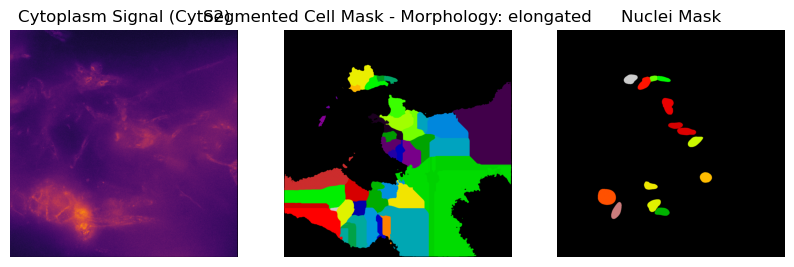

In [8]:
if in_notebook:
    plt.figure(figsize=(10, 10))
    plt.subplot(131)
    plt.imshow(cyto2[cyto2.shape[0] // 2], cmap="inferno")
    plt.title("Cytoplasm Signal (Cyto2)")
    plt.axis("off")
    plt.subplot(132)
    plt.imshow(cell_mask[cell_mask.shape[0] // 2], cmap="nipy_spectral")
    plt.title(f"Segmented Cell Mask - Morphology: {morphology_class}")
    plt.axis("off")
    plt.subplot(133)
    plt.imshow(nuclei_mask[nuclei_mask.shape[0] // 2], cmap="nipy_spectral")
    plt.title("Nuclei Mask")
    plt.axis("off")
    plt.show()

## run the mask reassignment function (post-hoc)
### This needs to occur after both nuclei and cell segmentations are done

In [9]:
cell_df = get_labels_for_post_hoc_reassignment(
    compartment_mask=cell_mask, compartment_name="cell"
)
nuclei_df = get_labels_for_post_hoc_reassignment(
    compartment_mask=nuclei_mask, compartment_name="nuclei"
)

In [10]:
nuclei_mask, reassigned_nuclei_df = run_post_hoc_mask_reassignment(
    nuclei_mask=nuclei_mask,
    cell_mask=cell_mask,
    nuclei_df=nuclei_df,
    cell_df=cell_df,
    return_dataframe=True,
)

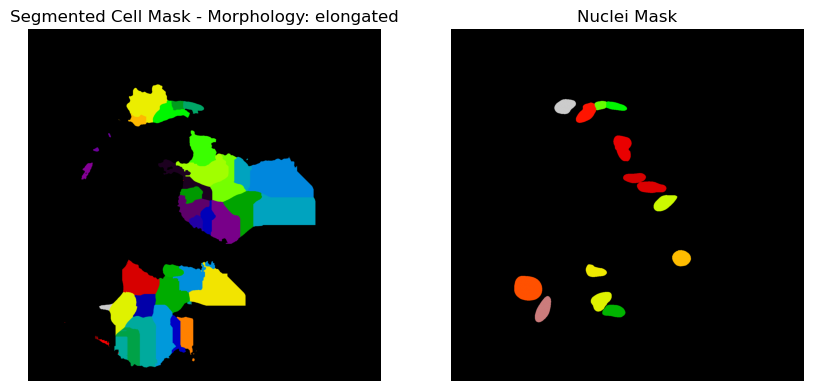

In [11]:
if in_notebook:
    plt.figure(figsize=(10, 10))
    plt.subplot(121)
    plt.imshow(cell_mask[cell_mask.shape[0] // 2], cmap="nipy_spectral")
    plt.title(f"Segmented Cell Mask - Morphology: {morphology_class}")
    plt.axis("off")
    plt.subplot(122)
    plt.imshow(nuclei_mask[nuclei_mask.shape[0] // 2], cmap="nipy_spectral")
    plt.title("Nuclei Mask")
    plt.axis("off")
    plt.show()

In [12]:
# refine the cell masks
# run the post hoc refinement step to reassign nuclei and cell masks to be the same label
# if they are "connected" i.e. if the nucleus is within the cell mask, then assign the same label to the cell mask as the nucleus mask
cell_mask = run_post_hoc_refinement(
    mask_image=cell_mask,
    sliding_window_context=3,
)

## Cytoplasm Segmentation

In [13]:
cytoplasm_mask = create_cytoplasm_masks(
    nuclei_masks=nuclei_mask,
    cell_masks=cell_mask,
)

## Organoid segmentation (derived from cell segmentation)

In [14]:
# convert the cell masks to binary masks
# the masks here are an array of every mask in the image.
cell_binary_mask = cell_mask.copy()
cell_binary_mask[cell_binary_mask > 0] = 1
# Fill holes in cell masks before generating organoid mask
for z in range(cell_binary_mask.shape[0]):
    cell_binary_mask[z] = scipy.ndimage.binary_fill_holes(
        cell_binary_mask[z].astype(bool)
    )
# make sure each instance has a unique integer label
organoid_mask = skimage.measure.label(cell_binary_mask)

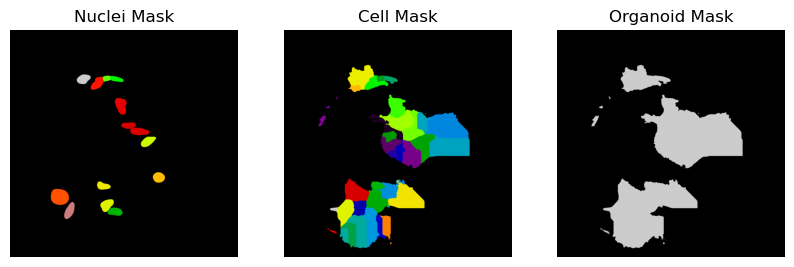

In [15]:
if in_notebook:
    z = cell_mask.shape[0] // 2
    plt.figure(figsize=(10, 10))
    plt.subplot(131)
    plt.title("Nuclei Mask")
    plt.imshow(nuclei_mask[z, :, :], cmap="nipy_spectral")
    plt.axis("off")
    plt.subplot(132)
    plt.title("Cell Mask")
    plt.imshow(cell_mask[z, :, :], cmap="nipy_spectral")
    plt.axis("off")
    plt.subplot(133)
    plt.title("Organoid Mask")
    plt.imshow(organoid_mask[z, :, :], cmap="nipy_spectral")
    plt.axis("off")
    plt.show()

## Remove border objects

In [16]:
# nuclei should already have objects removed at the border from the previous notebook,
# but we can run this again just to be safe
nuclei_mask = clean_border_objects(nuclei_mask, border_width=25)
cell_mask = clean_border_objects(cell_mask, border_width=25)
cytoplasm_mask = clean_border_objects(cytoplasm_mask, border_width=25)
organoid_mask = clean_border_objects(organoid_mask, border_width=25)

In [17]:
# since the nuclei - cell masks should be 1:1
# check if there are any singletons and remove those labels
unique_nuclei_labels = np.unique(nuclei_mask)
unique_cell_labels = np.unique(cell_mask)
unmatched_labels_to_remove = list(set(unique_nuclei_labels) - set(unique_cell_labels))


for label_id in unmatched_labels_to_remove:
    nuclei_mask = remove_label_id(nuclei_mask, label_id)
    cell_mask = remove_label_id(cell_mask, label_id)
    cytoplasm_mask = remove_label_id(cytoplasm_mask, label_id)

## Save the segmented masks

In [18]:
nuclei_mask_output = pathlib.Path(f"{mask_path}/nuclei_mask.tiff")
cell_mask_output = pathlib.Path(f"{mask_path}/cell_mask.tiff")
cytoplasm_mask_output = pathlib.Path(f"{mask_path}/cytoplasm_mask.tiff")
organoid_mask_output = pathlib.Path(f"{mask_path}/organoid_mask.tiff")
tifffile.imwrite(nuclei_mask_output, nuclei_mask)
tifffile.imwrite(cell_mask_output, cell_mask)
tifffile.imwrite(cytoplasm_mask_output, cytoplasm_mask)
tifffile.imwrite(organoid_mask_output, organoid_mask)

In [19]:
end_mem = psutil.Process(os.getpid()).memory_info().rss / 1024**2
end_time = time.time()
print(f"""
    Memory and time profiling for the run:\n
    Memory usage: {end_mem - start_mem:.2f} MB\n
    Time:\n
    --- %s seconds --- % {(end_time - start_time)}\n
    --- %s minutes --- % {((end_time - start_time) / 60)}\n
    --- %s hours --- % {((end_time - start_time) / 3600)}
""")


    Memory and time profiling for the run:

    Memory usage: 2805.11 MB

    Time:

    --- %s seconds --- % 146.57948875427246

    --- %s minutes --- % 2.4429914792378744

    --- %s hours --- % 0.040716524653964574



Note for an image of the pixel size (20, 1500, 1500) (Z,Y,X). 
This runs in under 1 minute on a CPU and uses less than 1GB of RAM.